# Machine learning: Predictive analysis on food inspection data using MLLib

This notebook demonstrates how to use **MLLib**, Spark's built-in machine learning libraries, to perform a simple predictive analysis on an open dataset.

--------

## What is MLLib?

MLLib is a core Spark library that provides a number of utilities that are useful for machine learning tasks, including utilities that are suitable for:

* Classification

* Regression

* Clustering

* Topic modeling

* Singular value decomposition (SVD) and principal component analysis (PCA)

* Hypothesis testing and calculating sample statistics

In this notebook, we describe a simple approach to *classification* through logistic regression.

---------

## What are classification and logistic regression?

*Classification*, a very common machine learning task, is the process of sorting input data into categories. It is the job of a classification algorithm to figure out how to assign "labels" to input data that you provide. For example, you could think of a machine learning algorithm that accepts stock information as input and divides the stock into two categories: stocks which you should sell and stocks which you should retain.

Logistic regression is the algorithm that you use for classification here. Spark's logistic regression API is useful for *binary classification*, or classifying input data into one of two groups. For more information about logistic regressions, see [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression).

In summary, the process of logistic regression produces a *logistic function* that can be used to predict the probability that an input vector belongs in one group or the other.  

----------

## What are we trying to accomplish in this notebook?

You will use Spark to perform some predictive analysis on food inspection data (**Food_Inspections1.csv**) that was acquired through the [City of Chicago data portal](https://data.cityofchicago.org/). This dataset contains information about food inspections that were conducted in Chicago, including information about each food establishment that was inspected, the violations that were found (if any), and the results of the inspection. This is not the raw data provided by the city: the raw data has been edited to make parsing easier, and we are only using about 1/10th of the complete dataset\*. You can download the raw data at the data portal website.

> \* *This site provides applications using data that has been modified for use from its original source, www.cityofchicago.org, the official website of the City of Chicago.  The City of Chicago makes no claims as to the content, accuracy, timeliness, or completeness of any of the data provided at this site.  The data provided at this site is subject to change at any time.  It is understood that the data provided at this site is being used at one’s own risk.*

In the steps below, you develop a model to see what it takes to pass or fail a food inspection. To do so, place the cursor in the cell and press **SHIFT + ENTER**. You can also click the **Run Cell** button from the menu above.

----------
## Notebook setup

When using PySpark kernel notebooks on HDInsight, there is no need to create a SparkContext or a SparkSession; a SparkSession which has the SparkContext is created for you automatically when you run the first code cell, and you'll be able to see the progress printed. The contexts are created with the following variable names:
- SparkSession (spark)

To run the cells below, place the cursor in the cell and then press **SHIFT + ENTER**.

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction, col
from pyspark.sql.types import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1597776479924_0004,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


--------

## Construct an input dataframe

We can use SparkSession to perform transformations on structured data. The first task is to load the sample data (**Food_Inspections1.csv**) into a Spark SQL *dataframe*. The sample data is by default available on the cluster. 

In [2]:
inspections = spark.read.csv('wasb:///HdiSamples/HdiSamples/FoodInspectionData/Food_Inspections1.csv', inferSchema=True)

Let's take a look at its schema:

In [3]:
inspections.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: integer (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: integer (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: string (nullable = true)

We now have the CSV file as a DataFrame. It has some columns we will not use. Dropping them can save memory when caching the DataFrame. Also, we should give these columns meaningful names.

In [4]:
# Helper function to drop unused columns and rename interesting columns.
def selectInterestingColumns(rawDf):
    # Mapping column index to name.
    columnNames = {0: "id", 1: "name", 12: "results", 13: "violations"}
    
    # Rename column from '_c{id}' to something meaningful.
    cols = [col(rawDf.columns[i]).alias(columnNames[i]) for i in columnNames.keys()]
    
    # Drop columns we are not using.
    df = rawDf.select(cols)
    
    # Replace null in column 'violations' with empty string. 
    # We are going to run LogisticRegression on this column and it doesn't like null.
    return df.fillna('', ["violations"])

In [5]:
df = selectInterestingColumns(inspections).cache()

# Do a count to cache the whole dataframe in memory
df.count()

13101

Let's take a look at the schema after transformation:

In [6]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- results: string (nullable = true)
 |-- violations: string (nullable = false)

Let us retrieve one row from the DataFrame to glimpse at the data.

In [7]:
df.take(1)

[Row(id=413707, name=u'LUNA PARK INC', results=u'Fail', violations=u'24. DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED - Comments: All dishwashing machines must be of a type that complies with all requirements of the plumbing section of the Municipal Code of Chicago and Rules and Regulation of the Board of Health. OBSEVERD THE 3 COMPARTMENT SINK BACKING UP INTO THE 1ST AND 2ND COMPARTMENT WITH CLEAR WATER AND SLOWLY DRAINING OUT. INST NEED HAVE IT REPAIR. CITATION ISSUED, SERIOUS VIOLATION 7-38-030 H000062369-10 COURT DATE 10-28-10 TIME 1 P.M. ROOM 107 400 W. SURPERIOR. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: Shielding to protect against broken glass falling into food shall be provided for all artificial lighting sources in preparation, service, and display facilities. LIGHT SHIELD ARE MISSING UNDER HOOD OF  COOKING EQUIPMENT AND NEED TO REPLACE LIGHT UNDER UNIT. 4 LIGHTS ARE O

The output of the above cell gives us an idea of the schema of the input file; the file includes the name of every establishment, the type of establishment, the address, the data of the inspections, and the location, among other things.

In [8]:
df.registerTempTable('CountResults')

We can perform our analysis on `df`. We've included 4 columns of interest in the dataframe: **id**, **name**, **results**, and **violations**. Let's get a small sample of the data:

In [9]:
df.show(5)

+------+--------------------+-------+--------------------+
|    id|                name|results|          violations|
+------+--------------------+-------+--------------------+
|413707|       LUNA PARK INC|   Fail|24. DISH WASHING ...|
|391234|       CAFE SELMARIE|   Fail|2. FACILITIES TO ...|
|413751|          MANCHU WOK|   Pass|33. FOOD AND NON-...|
|413708|BENCHMARK HOSPITA...|   Pass|                    |
|413722|           JJ BURGER|   Pass|                    |
+------+--------------------+-------+--------------------+
only showing top 5 rows

--------

## Understand the data

Let's start to get a sense of what our dataset contains. For example, what are the different values in the `results` column?

In [10]:
df.select('results').distinct().show()

+--------------------+
|             results|
+--------------------+
|                Fail|
|Business Not Located|
|  Pass w/ Conditions|
|     Out of Business|
|                Pass|
+--------------------+

You can run SQL queries using the `%%sql` directive. The `-o countResultsdf` argument will persist the output of the SQL query as a Pandas dataframe, with the name `countResultdf` on the Jupyter server.

In [11]:
%%sql -o count_results_df
SELECT results, COUNT(results) AS cnt FROM CountResults GROUP BY results ORDER BY cnt DESC

A quick visualization can help us reason about the distribution of these outcomes.

If you want to construct your own custom visualization of the data, use the `countResultsdf` dataframe which persists the results of a SQL query out of the cluster and onto the Jupyter server, and generate a plot with Matplotlib. In such a scenario where the data is available locally on the Jupyter server, you can use the `%%local` magic. You can use regular Python code with the magic.

>**Matplotlib** is a library used to construct a visualization of the data.

(-1.0119403344538858,
 1.0000000000185918,
 -1.008810095783151,
 1.0072197845427724)

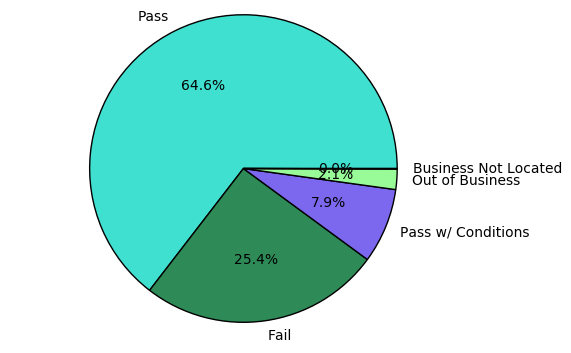

In [12]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt


labels = count_results_df['results']
sizes = count_results_df['cnt']
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')

You can see that there are 5 distinct results that an inspection can have

* Business not located 
* Fail
* Pass
* Pass w/ conditions, and
* Out of Business 

Let us develop a model that can guess the outcome of a food inspection, given the violations. Since logistic regression is a binary classification method, it makes sense to group our data into two categories: **Fail** and **Pass**. A "Pass w/ Conditions" is still a Pass, so when we train the model, we will consider the two results equivalent. Data with the other results ("Business Not Located", "Out of Business") are not useful so we will remove them from our training set. This should be okay since these two categories make up a very small percentage of the results anyway.

Let us go ahead and convert our existing dataframe(`df`) into a new dataframe where each inspection is represented as a label-violations pair. In our case, a label of `0.0` represents a failure, a label of `1.0` represents a success, and a label of `-1.0` represents some results besides those two. We will filter those other results out when computing the new data frame.

In [13]:
# Note: We can do the same thing with pyspark.sql.functions.when(). It doesn't use UDF and is faster.
# However, we would like to demonstrate UserDefinedFunction here as an example.
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = df.select(label(df.results).alias('label'), df.violations).where('label >= 0')

Let's retrieve one row from the labeled data to see what it looks like.

In [14]:
labeledData.take(1)

[Row(label=0.0, violations=u'24. DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED - Comments: All dishwashing machines must be of a type that complies with all requirements of the plumbing section of the Municipal Code of Chicago and Rules and Regulation of the Board of Health. OBSEVERD THE 3 COMPARTMENT SINK BACKING UP INTO THE 1ST AND 2ND COMPARTMENT WITH CLEAR WATER AND SLOWLY DRAINING OUT. INST NEED HAVE IT REPAIR. CITATION ISSUED, SERIOUS VIOLATION 7-38-030 H000062369-10 COURT DATE 10-28-10 TIME 1 P.M. ROOM 107 400 W. SURPERIOR. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: Shielding to protect against broken glass falling into food shall be provided for all artificial lighting sources in preparation, service, and display facilities. LIGHT SHIELD ARE MISSING UNDER HOOD OF  COOKING EQUIPMENT AND NEED TO REPLACE LIGHT UNDER UNIT. 4 LIGHTS ARE OUT IN THE REAR CHILDREN AREA,IN THE KIND

---------

## Create a logistic regression model from the input dataframe

Our final task is to convert the labeled data into a format that can be analyzed by logistic regression. The input to a logistic regression algorithm should be a set of *label-feature vector pairs*, where the "feature vector" is a vector of numbers that represents the input point in some way. So, we need a way to convert the "violations" column, which is semi-structured and contains a lot of comments in free-text, to an array of real numbers that a machine could easily understand. 

One standard machine learning approach for processing natural language is to assign each distinct word an "index", and then pass a vector to the machine learning algorithm such that each index's value contains the relative frequency of that word in the text string. 

MLLib provides an easy way to perform this operation. First, we'll "tokenize" each violations string to get the individual words in each string, and then we'll use a `HashingTF` to convert each set of tokens into a feature vector which can then be passed to the logistic regression algorithm to construct a model. We'll conduct all of these steps in sequence using a "pipeline".

In [15]:
tokenizer = Tokenizer(inputCol="violations", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

model = pipeline.fit(labeledData)
model

PipelineModel_48b693fa5706170b75eb

We now have a trained logistic regression model to classify input data. 

-----------

## Evaluate the model on a separate test dataset

We can use the model we created earlier to *predict* what the results of new inspections will be, based on the violations that were observed. We trained this model on the dataset **Food_Inspections1.csv**. Let us use a second dataset, **Food_Inspections2.csv**, to *evaluate* the strength of this model on new data. This second data set should already be in the default storage container associated with the cluster.

The snippet below creates a new dataframe, **predictionsDf** that contains the prediction generated by the model.

In [16]:
testData = selectInterestingColumns(spark.read.csv('wasb:///HdiSamples/HdiSamples/FoodInspectionData/Food_Inspections2.csv', inferSchema=True))
testDf = testData.where("results = 'Fail' OR results = 'Pass' OR results = 'Pass w/ Conditions'")

predictionsDf = model.transform(testDf)
predictionsDf.registerTempTable('Predictions')
predictionsDf.columns

['id', 'name', 'results', 'violations', 'words', 'features', 'rawPrediction', 'probability', 'prediction']

Let's look at one of the predictions.

In [17]:
predictionsDf.take(1)

[Row(id=580320, name=u"COUSIN'S GRILL", results=u'Fail', violations=u'37. TOILET ROOM DOORS SELF CLOSING: DRESSING ROOMS WITH LOCKERS PROVIDED: COMPLETE SEPARATION FROM LIVING/SLEEPING QUARTERS - Comments: INSTRUCTED TO FIX BROKEN SELF CLOSING DEVICE AT WASHROOM DOOR. | 40. REFRIGERATION AND METAL STEM THERMOMETERS PROVIDED AND CONSPICUOUS - Comments: All food establishments that display, prepare, or store potentially hazardous foods shall have calibrated metal stem thermometers, provided and conspicuous, for refrigerated and hot food units.  INSTRUCTED TO PROVIDE THERMOMETTER VISIBLE INSIDE ALL COOLERS. | 36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED - Comments: Shielding to protect against broken glass falling into food shall be provided for all artificial lighting sources in preparation, service, and display facilities.  LIGHTBULBS MUST BE SHIELDED INSIDE HOT HOLDING DISPLAY UNIT OR PROVIDE SHATTERFROOFED LIGHTBULB.   | 18. NO EVIDENCE OF RODENT OR

The `model.transform()` method will apply the same transformation to any new data with the same schema, and arrive at a prediction of how to classify the data. We can do some simple statistics to get a sense of how accurate our predictions were:

In [18]:
numSuccesses = predictionsDf.where("""(prediction = 0 AND results = 'Fail') OR 
                                      (prediction = 1 AND (results = 'Pass' OR 
                                                           results = 'Pass w/ Conditions'))""").count()
numInspections = predictionsDf.count()

print("There were %d inspections and there were %d successful predictions" % (numInspections, numSuccesses))
print("This is a %d%% success rate" % (float(numSuccesses) / float(numInspections) * 100))

There were 9315 inspections and there were 8110 successful predictions
This is a 87% success rate

Using logistic regression with Spark gives us an accurate model of the relationship between violations descriptions in English and whether a given business would pass or fail a food inspection. We can construct a final visualization to help us reason about the results of this test. Let's first use a set of SQL queries to count the successful and failed predictions (we're using the `-q` option to turn off visualizations).

In [19]:
%%sql -q -o true_positive
SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND results = 'Fail'

In [20]:
%%sql -q -o false_positive
SELECT count(*) AS cnt FROM Predictions WHERE prediction = 0 AND (results = 'Pass' OR results = 'Pass w/ Conditions')

In [21]:
%%sql -q -o true_negative
SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND results = 'Fail' 

In [22]:
%%sql -q -o false_negative
SELECT count(*) AS cnt FROM Predictions WHERE prediction = 1 AND (results = 'Pass' OR results = 'Pass w/ Conditions')

Finally, we use these quantities to construct a visualization with **Matplotlib**:

(-1.0183947086334229, 1.0, -1.0172438621520996, 1.0000982284545898)

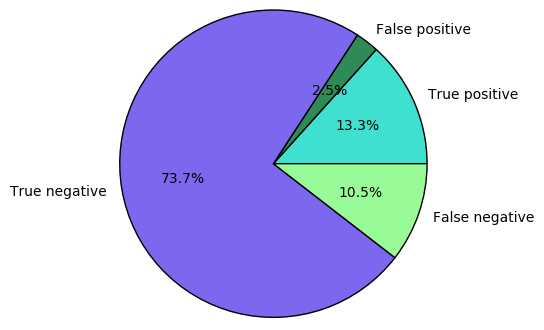

In [23]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt

labels = ['True positive', 'False positive', 'True negative', 'False negative']
sizes = [true_positive['cnt'], false_positive['cnt'], false_negative['cnt'], true_negative['cnt']]
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')

In this chart, a "positive" result refers to the failed food inspection, while a negative result refers to a passed inspection. 